# Выбор локации для скважины

# Описание проекта

Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv. 
- geo_data_1.csv. 
- geo_data_2.csv. 

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).


**Условия задачи**:<br>
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

In [2]:
geodata1, geodata2, geodata3 = (pd.read_csv('geo_data_0.csv'),
                                pd.read_csv('geo_data_1.csv'),
                                pd.read_csv('geo_data_2.csv'))

In [3]:
geodata1.info()
print('\n')
geodata2.info()
print('\n')
geodata3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-N

In [4]:
display(geodata1.duplicated().sum())
display(geodata2.duplicated().sum())
display(geodata3.duplicated().sum())

0

0

0

Пропусков и дубликатов нет во всех трёх наборах

Далее, выведем информацию о распределении значений всех признаков и их зависимости друг от друга 

In [5]:
def describe(df):
    display(df.describe())
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title('Корреляция между признаками', size = 12)
    a = sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'RdBu', square=True, linewidths=0.5)
    
    b = sns.pairplot(df, diag_kind = "hist", diag_kws = {'bins':50})
    plt.suptitle('Диагарммы рассеяния пар признаков и гистограммы', size = 12, y = 1)

### Обзор данных по региону 1

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


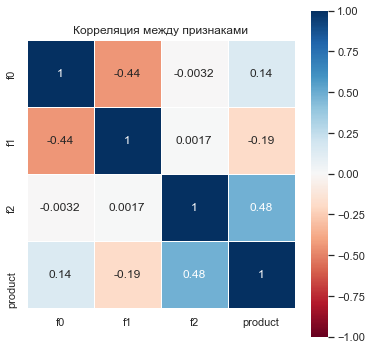

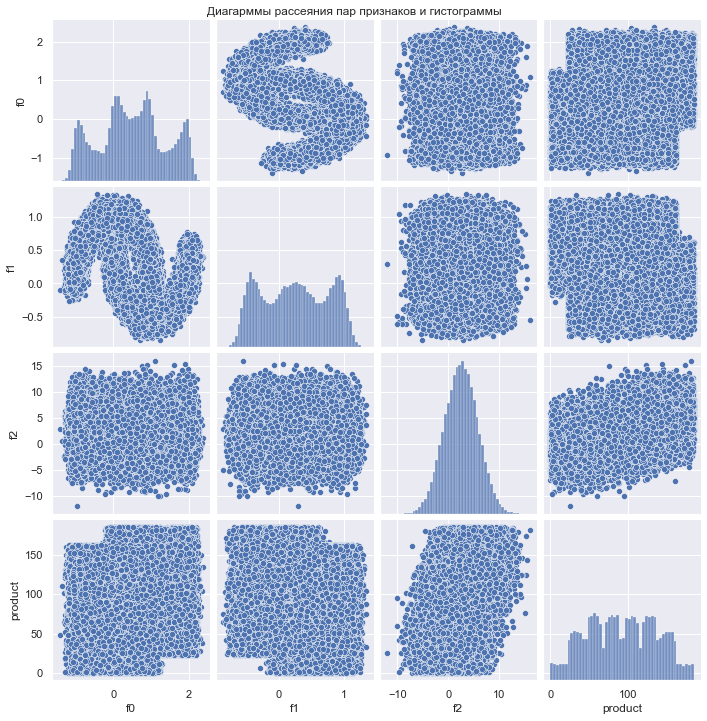

In [6]:
describe(geodata1)

- Самая большой коэффициент корреляции у целевого признака - *product* с признаком *f2* = 0.48, обычно, такое значение считается умеренным, также есть слабая взаимосвязь с остальными признаками
- распределение значений *product* не нормально, имеется несколько выраженных пиков

### Обзор данных по региону 2

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


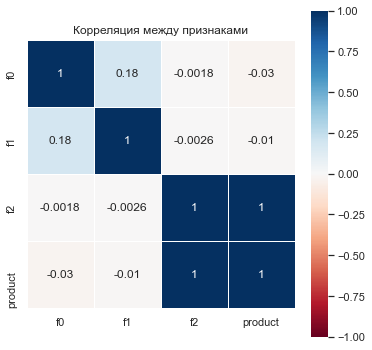

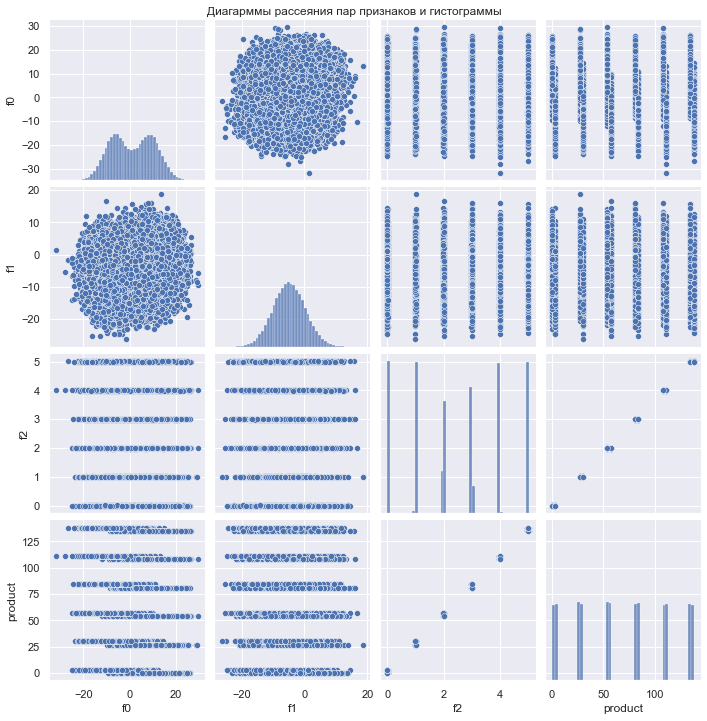

In [7]:
describe(geodata2)

- Самая большой коэффициент корреляции у целевого признака - *product* с признаком *f2* = 1
- значения столбца product, как и f2, четко разделены на 6 парных групп примерно одинакового размера

### Обзор данных по региону 3

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


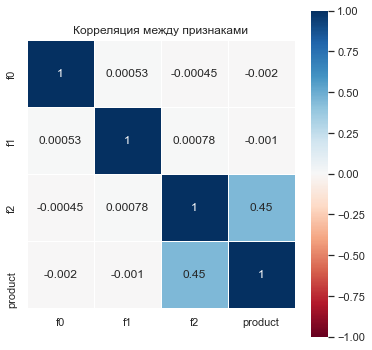

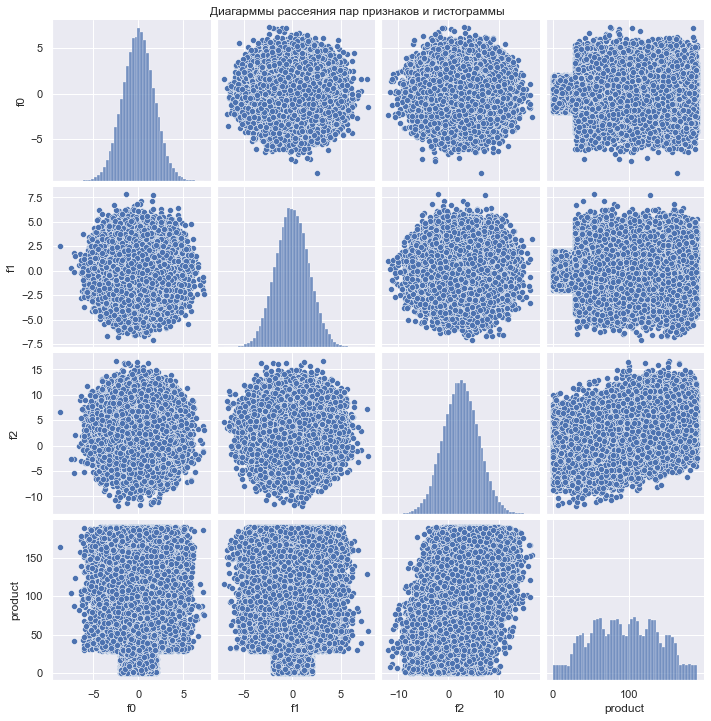

In [8]:
describe(geodata3)

Ситуация схожая с регионом 1, но взаимосвязь признаков f0 и f1 с product практически отсутствует

### Вывод

Между наборами данных имеются сильные различия и потребуется для каждого использовать отдельную модель машинного обучения для предсказания значений

Второй регион - самый предсказуемый, но при этом обладает самыми низкими средним и максимальным значениями объема запасов

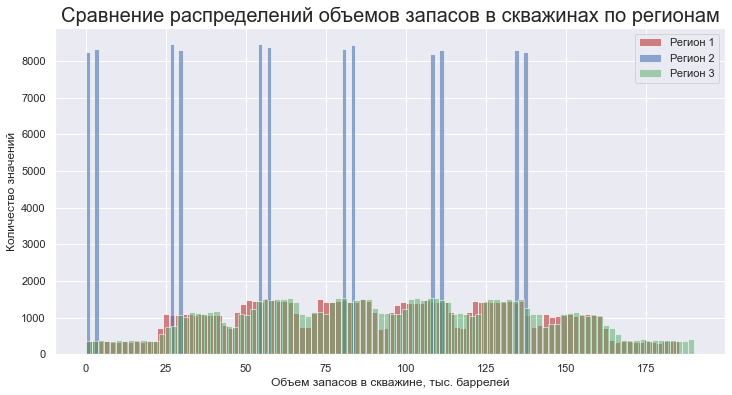

In [9]:
plt.figure(figsize=(12,6))
geodata1['product'].hist(bins = 100, color = 'r', alpha = 0.7)
geodata2['product'].hist(bins=100, color = 'b', alpha = 0.6)
geodata3['product'].hist(bins=100, color = 'g', alpha = 0.5)
plt.xlabel('Объем запасов в скважине, тыс. баррелей')
plt.ylabel('Количество значений')
plt.title('Сравнение распределений объемов запасов в скважинах по регионам', size = '20')
plt.legend(['Регион 1', 'Регион 2', 'Регион 3'])

plt.show()

Наконец, исключим столбец *id* из данных, так как он в данном случае не важен

In [10]:
geodata1, geodata2, geodata3 = geodata1.drop('id', axis = 1),geodata2.drop('id', axis = 1),geodata3.drop('id', axis = 1)

## Обучение и проверка модели

С помощью функции:
 - разделим кажый набор данных на обучающую и валидационную выборки в соотношении 75/25
 - обучим модель Линейной Регрессии
 - рассчитаем среднее значение предсказанных объемов
 - рассчитаем RMSE

In [11]:
def output_predictions(df):
    # Набор данных делится на целевой и независимые признаки
    X = df.drop('product', axis= 1)
    Y = df['product']
    # Наборы делятся на тренировочную и тестовую выборки
    features_train, features_test, targets_train, targets_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
    
    # Создаётся и обучается модель, получаем предсказания для тест. выборки и RMSE
    model = LinearRegression()
    model.fit(features_train, targets_train)
    predictions = model.predict(features_test)
    predictions = predictions.round(decimals = 3)
    RMSE = round(mean_squared_error(targets_test, predictions)**0.5, 3)
    predictions = pd.Series(predictions)
    predictions.index = targets_test.index
    #Возвращаем RMSE, предсказания и действительные значения
    return RMSE, predictions, targets_test
    

In [12]:
RMSE_1, predictions_1, actuals_1 = output_predictions(geodata1)
print(f'''Для региона 1: 
    Предсказанный средний объем запасов на точку: {predictions_1.mean():.2f} тыс. баррелей, 
    Действительный средний объем запасов в валидационной выборке: {actuals_1.mean():.2f} тыс. баррелей,
    RMSE: {RMSE_1}''')

Для региона 1: 
    Предсказанный средний объем запасов на точку: 92.40 тыс. баррелей, 
    Действительный средний объем запасов в валидационной выборке: 92.33 тыс. баррелей,
    RMSE: 37.757


In [13]:
RMSE_2, predictions_2, actuals_2 = output_predictions(geodata2)
print(f'''Для региона 2:
    Предсказанный средний объем запасов на точку: {predictions_2.mean():.2f} тыс. баррелей, 
    Действительный средний объем запасов в валидационной выборке: {actuals_2.mean():.2f} тыс. баррелей,
    RMSE: {RMSE_2}''')

Для региона 2:
    Предсказанный средний объем запасов на точку: 68.71 тыс. баррелей, 
    Действительный средний объем запасов в валидационной выборке: 68.73 тыс. баррелей,
    RMSE: 0.89


In [14]:
RMSE_3, predictions_3, actuals_3 = output_predictions(geodata3)
print(f'''Для региона 3:
    Предсказанный средний объем запасов на точку: {predictions_3.mean():.2f} тыс. баррелей, 
    Действительный средний объем запасов в валидационной выборке: {actuals_3.mean():.2f} тыс. баррелей,
    RMSE: {RMSE_3}''')

Для региона 3:
    Предсказанный средний объем запасов на точку: 94.77 тыс. баррелей, 
    Действительный средний объем запасов в валидационной выборке: 95.15 тыс. баррелей,
    RMSE: 40.146


In [21]:
data = {1: [predictions_1, actuals_1],
       2: [predictions_2, actuals_2],
       3: [predictions_3, actuals_3]}

Лучше всего Линейная Регрессия работает со вторым регионом, что не удивительно, учитывая коэффициенты взаимосвязи между целевым и остальными признаками данных по нему.

Для первого и третьего регионов, при большем среднем значении значительно больше RMSE - почти половина от среднего.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [16]:
BUDGET = 10*1e9
NUM_SPOTS = 500
N_BEST_SPOTS = 200
PRODUCT_INCOME_PER_UNIT = 450000

In [17]:
print('Для безубыточной разработки {} скважин нужно получить в среднем по {:.2f} тыс. баррелей с каждой'
      .format(N_BEST_SPOTS, BUDGET/PRODUCT_INCOME_PER_UNIT/N_BEST_SPOTS))

Для безубыточной разработки 200 скважин нужно получить в среднем по 111.11 тыс. баррелей с каждой


Полученное значение больше, чем среднее, предсказанное по любому из регионов. 


Напишем функцию, в которой из полученных предсказаний будут выбираться 200 лучших для разработки скважин и считаться прибыль от их разработки

In [18]:
def profit(actual, predicted):
    top200 = predicted.sort_values(ascending=False).head(N_BEST_SPOTS).index
    profit = (actual[top200].sum()*PRODUCT_INCOME_PER_UNIT)-BUDGET
    
    return profit

## Расчёт прибыли и рисков 

In [22]:

key = 1
# словарь для хранения распределений потенциальной прибыли по регионам, значений рисков
revenue_distributions = {}
for prediction, target in data.values():
    revenue_distributions[key] = []
    # перебирая предсказния и действительные значения, сохранённые ранее выполняем бутстреп 100 раз,
    # считаем возможную выручку для каждого региона и получаем распределение значений
    state = RandomState(42)
    values = []
    for i in range(1000):
        data_sample = prediction.sample(n = NUM_SPOTS, replace = True, random_state=state)
        values.append(profit(target, data_sample))
    values = pd.Series(values)
    values = values
    #риск вычисляем как долю отрицательных значений от общего количества значений 
    risk = (values < 0).mean()*100
    #risk = len(values[values<0])*100/len(values)
    
    # доверительный интервал вычисляем, взяв квантили
    confidence_interval = []
    confidence_interval.append(round(values.quantile(.025)/1e6, 1))
    confidence_interval.append(round(values.quantile(.975)/1e6, 1))
    
    #confidence_interval = st.t.interval(0.95, len(values)-1, loc = values.mean(), scale = values.sem())
    #confidence_interval = (round(confidence_interval[0]/1e6, 1), round(confidence_interval[1]/1e6, 1))
    # добавляем полученный набор в словарь
    revenue_distributions[key].append(values)
    revenue_distributions[key].append(risk)
    revenue_distributions[key].append(confidence_interval)
    revenue_distributions[key].append(values.mean())
    key +=1
    

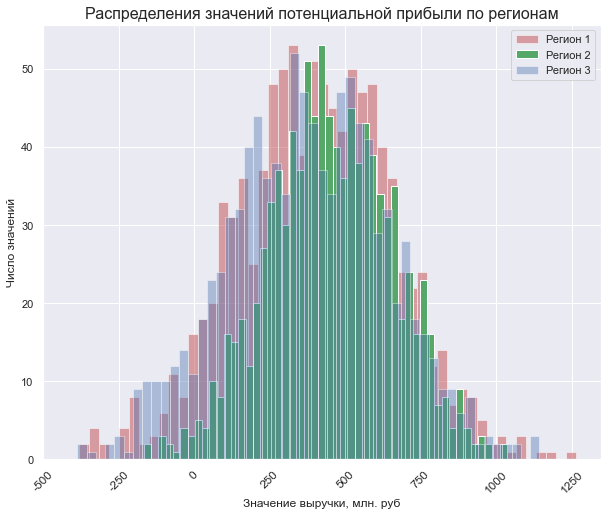

Для региона 1:
    	Среднее значение прибыли: 399.5 млн. руб;
    	95% доверительный интервал : [-115.7, 897.5] (млн. руб)
    	Риск убытков составляет 6.0%
Для региона 2:
    	Среднее значение прибыли: 452.0 млн. руб;
    	95% доверительный интервал : [61.7, 845.3] (млн. руб)
    	Риск убытков составляет 1.5%
Для региона 3:
    	Среднее значение прибыли: 375.0 млн. руб;
    	95% доверительный интервал : [-144.8, 888.4] (млн. руб)
    	Риск убытков составляет 8.0%


In [23]:
# строим гистограмму на основе собранных данных и выводим информацию
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
#sns.distplot(revenue_distributions[1][0], color = 'r', alpha = 0.3)
#sns.distplot(revenue_distributions[2][0], color = 'g', alpha = 1)
#sns.distplot(revenue_distributions[3][0], color = 'b', alpha = 0.3)
revenue_distributions[1][0].hist(alpha = 0.5, color = 'r', bins = 50)
revenue_distributions[2][0].hist(alpha = 1, color = 'g', bins = 50)
revenue_distributions[3][0].hist(alpha = 0.4, color = 'b', bins = 50)
plt.legend(['Регион 1', 'Регион 2', 'Регион 3'])
plt.title('Распределения значений потенциальной прибыли по регионам', size = 16)
plt.xticks(np.arange(-500*1e6, 1251*1e6, 250*1e6),np.arange(-500, 1251, 250), rotation=45, size=12)
plt.xlabel('Значение выручки, млн. руб', size = 12)
plt.ylabel('Число значений', size = 12)

plt.show() 
for key in range(1,4):
    print('''Для региона {}:
    \tСреднее значение прибыли: {:.1f} млн. руб;
    \t95% доверительный интервал : {} (млн. руб)
    \tРиск убытков составляет {:.1f}%'''.format(key, (revenue_distributions[key][3])/1e6, revenue_distributions[key][2], revenue_distributions[key][1] ))
    key +=1

## Вывод
Для разработки рекомендован регион 2 (соответствующий geo_data1.csv) как единственный отвечающий критерию **Риск < 2.5%**, но, даже если не учитывать критерий:
 - Риск убытков минимален в сравнении с другими регионами, и в случае убытков потери *относительно* невелики;
 - Является самым предсказуемым для моделирования;
 - Показал самое высокое значение потенциальной выручки.